In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import load_csv, split_date, drop_columns, impute_rolling_median, add_seasonality, create_lags, apply_moving_average_for_roc, split_data_frame, create_sequences, simplify_df, trigonometric_date_encoding

In [2]:
df = load_csv('../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38656 entries, 0 to 38655
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               38656 non-null  int64         
 1   time                    38656 non-null  datetime64[ns]
 2   open                    38656 non-null  float64       
 3   close                   38656 non-null  float64       
 4   high                    38656 non-null  float64       
 5   low                     38656 non-null  float64       
 6   volume_24h              38656 non-null  float64       
 7   circulating_supply      38656 non-null  float64       
 8   day                     38656 non-null  int32         
 9   month                   38656 non-null  int32         
 10  year                    38656 non-null  int32         
 11  Month_Category_Bearish  38656 non-null  float64       
 12  Month_Category_Bullish  38656 non-null  float6

In [4]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.1)
train = df.iloc[:train_size, :]
val = df.iloc[train_size : train_size + val_size, :]
test = df.iloc[train_size + val_size :, :]

In [5]:
train = trigonometric_date_encoding(train)
val = trigonometric_date_encoding(val)
test = trigonometric_date_encoding(test)

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], format="%d-%m-%Y")
/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Foreca

In [6]:
train.head()

,timestamp,time,open,close,high,low,volume_24h,circulating_supply,day,month,year,Month_Category_Bearish,Month_Category_Bullish,Month_Category_Normal,ROC_0,ROC_1,ROC_2,sin_date,cos_date
0,1567036800,2019-08-29,9699.30,9492.81,9709.59,9344.69,2.119802e+10,18461987.0,29,8,2019,0.0,1.0,0.0,0,0,1,0.433884,-0.900969
1,1567123200,2019-08-30,9453.74,9587.25,9699.85,9368.27,2.119802e+10,18461987.0,30,8,2019,0.0,1.0,0.0,0,0,1,-0.433884,-0.900969
2,1567209600,2019-08-31,9603.96,9624.54,9714.11,9512.03,2.119802e+10,18461987.0,31,8,2019,0.0,1.0,0.0,0,0,1,-0.974928,-0.222521
3,1567296000,2019-09-01,9646.58,9768.36,9823.53,9578.66,2.119802e+10,18461987.0,1,9,2019,0.0,0.0,1.0,0,0,1,-0.781831,0.623490
4,1567382400,2019-09-02,9783.44,10387.50,10459.00,9764.76,2.119802e+10,18461987.0,2,9,2019,0.0,0.0,1.0,0,0,1,0.000000,1.000000


In [7]:
excluded_columns = ["sin_date", "cos_date", "Month_Category_Bearish", "Month_Category_Bullish", "Month_Category_Normal"]
features_to_standardize = [column for column in train.columns if column not in excluded_columns]

# Calculate the mean and standard deviation only for the required columns
train_mean = train[features_to_standardize].mean()
train_std = train[features_to_standardize].std()

# Standardize only the required columns in the train, validation, and test sets
train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std

/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76058/575569399.py:9: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  train[features_to_standardize] = (train[features_to_standardize] - train_mean) / train_std
/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76058/575569399.py:10: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  val[features_to_standardize] = (val[features_to_standardize] - train_mean) / train_std
/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76058/575569399.py:11: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  test[features_to_standardize] = (test[features_to_standardize] - train_mean) / train_std


In [8]:
features_to_standardize

['timestamp',
 'time',
 'open',
 'close',
 'high',
 'low',
 'volume_24h',
 'circulating_supply',
 'day',
 'month',
 'year',
 'ROC_0',
 'ROC_1',
 'ROC_2']

In [9]:
X_train, y_train = create_sequences(train, 5)
X_val, y_val = create_sequences(val, 5)
X_test, y_test = create_sequences(test, 5)

In [10]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((30918, 5, 19), (30918,), (3859, 5, 19), (3859,), (3861, 5, 19), (3861,))

In [11]:
# Convert the numpy arrays to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')

In [12]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model as tfkModel

def build_improved_LSTM_CNN(input_shape, output_units):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # CNN Layer 1
    cnn = tfkl.Conv1D(256, 3, padding='same')(input_layer)  # Increased number of filters and adjusted kernel size
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D(pool_size=2)(cnn)  # Added pool_size

    # CNN Layer 2
    cnn = tfkl.Conv1D(128, 3, padding='same')(cnn)  # Adjusted number of filters and kernel size
    cnn = tfkl.LeakyReLU(alpha=0.2)(cnn)
    cnn = tfkl.MaxPooling1D(pool_size=2)(cnn)  # Added pool_size

    # LSTM Layer 1
    lstm = tfkl.LSTM(128, return_sequences=True)(cnn)  # Increased the number of units
    lstm = tfkl.Dropout(0.2)(lstm)  # Added dropout for regularization

    # LSTM Layer 2
    lstm = tfkl.LSTM(128)(lstm)  # Adjusted the number of units
    lstm = tfkl.Dropout(0.2)(lstm)  # Added dropout for regularization
    
    # Feature Extractor Layer
    dense = tfkl.Dense(64)(lstm)  # Adjusted the number of units
    dense = tfkl.LeakyReLU(alpha=0.2)(dense)
    dense = tfkl.Dropout(0.2)(dense)  # Added dropout for regularization

    # Output layer for regression
    output_layer = tfkl.Dense(output_units)(dense)  # No activation for regression output

    # Connect input and output through the Model class
    model = tfkModel(inputs=input_layer, outputs=output_layer, name='Improved_LSTM_CNN')

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

# Assuming input_shape is (t, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = 1  # Number of days to predict

# Build and compile the model
model = build_improved_LSTM_CNN(input_shape, output_units)
model.summary()

# Train the model
history = model.fit(
x=X_train,
y=y_train,
batch_size=32,
validation_data=(X_val, y_val),
epochs=100,
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
]
).history


Model: "Improved_LSTM_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5, 19)]           0         
                                                                 
 conv1d (Conv1D)             (None, 5, 256)            14848     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5, 256)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 256)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 128)            98432     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 2, 128)            0         
                                                 

In [13]:
def evaluate(model, X_test, y_test):
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')
    model.evaluate(X_test, y_test, verbose=1)
    y_pred = model.predict(X_test)
    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(y_test, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

967/967 [==============================] - 2s 2ms/step


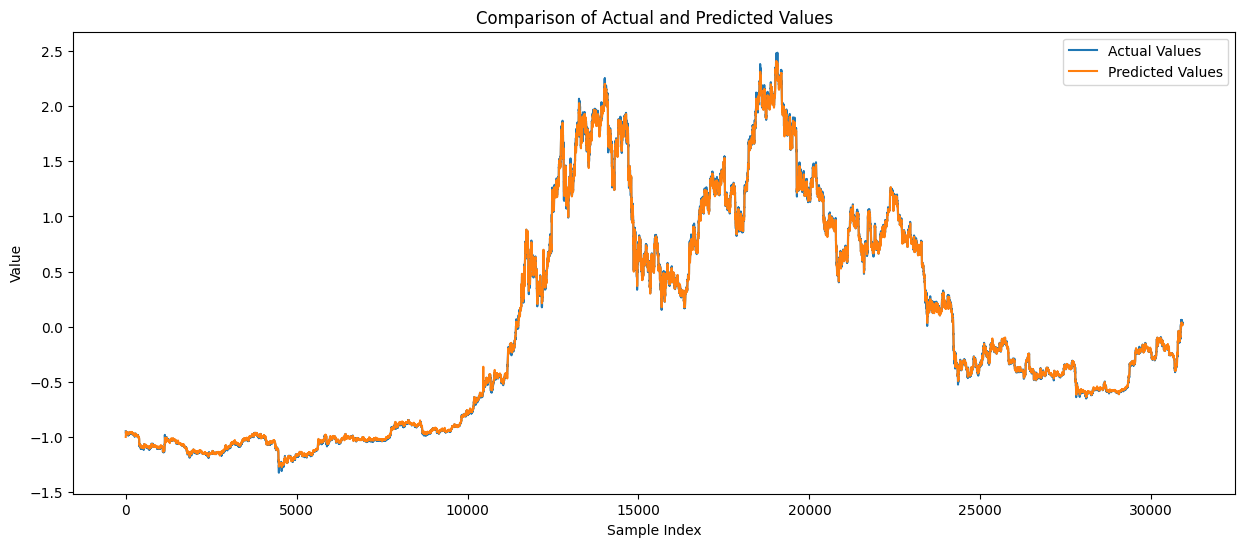

In [14]:
evaluate(model, X_train, y_train)

121/121 [==============================] - 0s 2ms/step


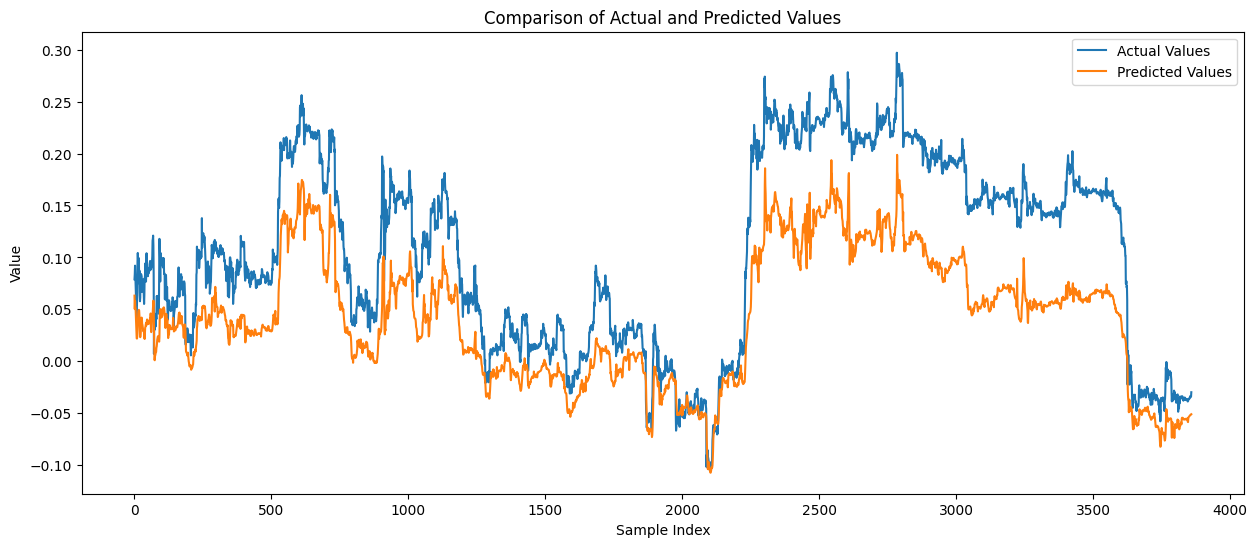

In [15]:
evaluate(model, X_val, y_val)

121/121 [==============================] - 0s 2ms/step


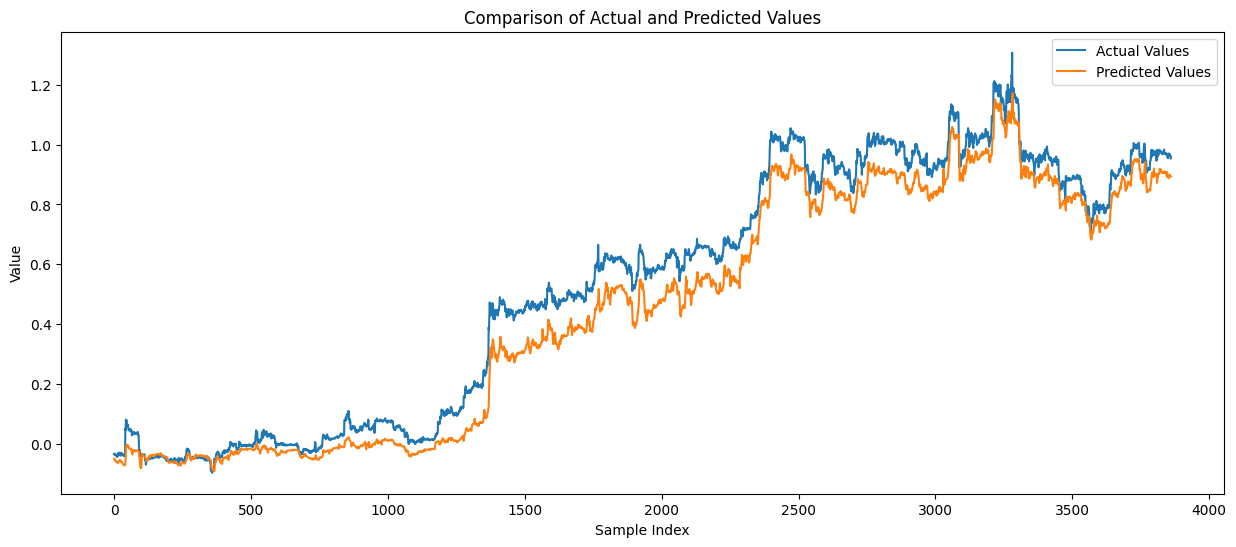

In [16]:
evaluate(model, X_test, y_test)

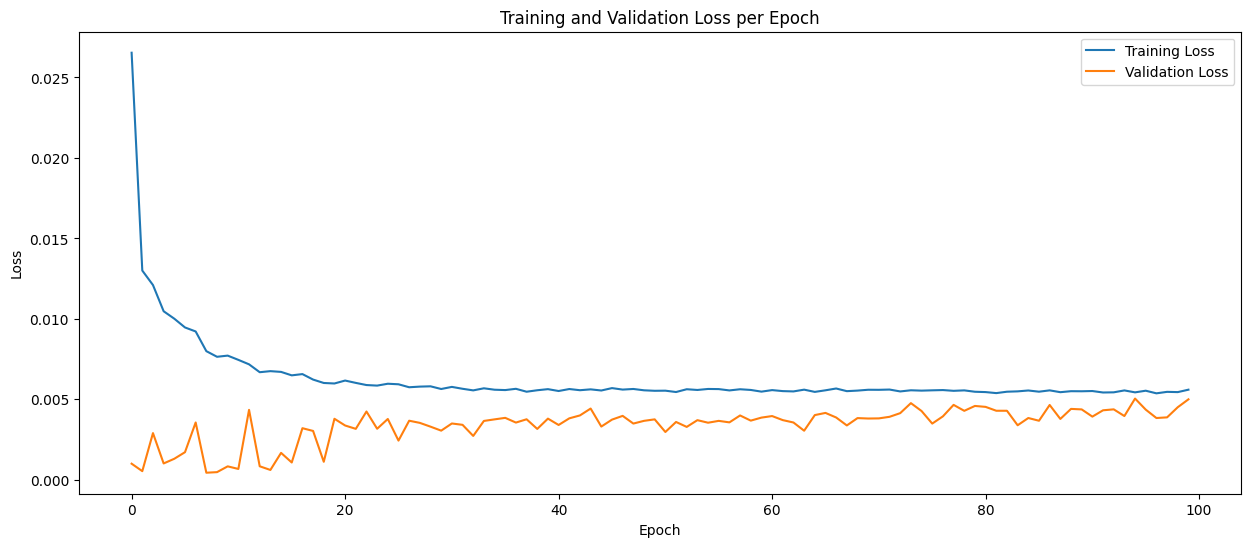

In [17]:
import matplotlib.pyplot as plt

# Extracting loss data from the history object
train_loss = history['loss']
val_loss = history['val_loss']

# Number of epochs actually completed (may be less than 50 due to early stopping)
epochs = range(len(train_loss))

# Plotting the loss per epoch
plt.figure(figsize=(15, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()